In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import seaborn as sns
from scipy.special import comb
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import LogNorm
import matplotlib as mpl
import pandas as pd
import itertools as it
import matplotlib.colors as colors

from mutation_info import *

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return it.chain.from_iterable(it.combinations(s, r) for r in range(len(s)+1))

plt.rcParams.update({'font.size': 7})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [2]:
# set some things
num_mutations_MA = 16
order_MA = 5
num_term_list_MA = np.array([int(comb(num_mutations_MA,i)) for i in range(1,order_MA+1)])
total_params_MA = sum(num_term_list_MA)
order_start_indices_MA = list(np.cumsum(num_term_list_MA)+1)
order_start_indices_MA.insert(0,1)
print(num_term_list_MA,total_params_MA)
print(order_start_indices_MA)

num_mutations_SI = 15
order_SI = 5
num_term_list_SI = np.array([int(comb(num_mutations_SI,i)) for i in range(1,order_SI+1)])
total_params_SI = sum(num_term_list_SI)
order_start_indices_SI = list(np.cumsum(num_term_list_SI)+1)
order_start_indices_SI.insert(0,1)
print(num_term_list_SI,total_params_SI)
print(order_start_indices_SI)

num_mutations_G189E = 16
order_G189E = 6
num_term_list_G189E = np.array([int(comb(num_mutations_G189E,i)) for i in range(1,order_G189E+1)])
total_params_G189E = sum(num_term_list_G189E)
order_start_indices_G189E = list(np.cumsum(num_term_list_G189E)+1)
order_start_indices_G189E.insert(0,1)
print(num_term_list_G189E,total_params_G189E)
print(order_start_indices_G189E)


mut_names = ['N26D','S29R','Y35N','Y48C','D49Y','V98I','G31D','Y33H','M34I','H35N','N52H','G57D','L83V','S84N','R85G','R87K']

MA_color = '#E8735C'
SI_color = 'teal'
G189E_color = 'powderblue'


ep_type = 'stat'

[  16  120  560 1820 4368] 6884
[1, 17, 137, 697, 2517, 6885]
[  15  105  455 1365 3003] 4943
[1, 16, 121, 576, 1941, 4944]
[  16  120  560 1820 4368 8008] 14892
[1, 17, 137, 697, 2517, 6885, 14893]


# MA90

In [3]:
# read model coefficients


coefs_MA = np.zeros(total_params_MA+1)
stderr_MA = np.zeros(total_params_MA+1)
names_MA = []
sig_MA = np.full((total_params_MA+1),0)
cis_MA = np.zeros((total_params_MA+1,2))

with open('../../Epistasis_Inference/MA90/statistical/CH65_MA90_102022_'+str(order_MA)+'order_stat.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    print(r2_train)
    header = next(coef_reader)
    print(header)
    for i in range(total_params_MA+1):
        row = next(coef_reader)
        names_MA.append(row[0])
        coefs_MA[i] = float(row[1])
        if i >= 1:
            stderr_MA[i] = float(row[2])
            cis_MA[i,0] = float(row[4])
            cis_MA[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_MA[i] = 1
    readfile.close()
            
print(len(coefs_MA))      

0.9899539030408634
['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper']
6885


0.0 0.3822188405759629


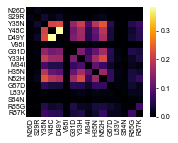

In [4]:
# initialize matrices to store values

# total (lower diagonal)
total_epistasis = np.zeros((16,16),dtype=float)
for i in range(16):  
    total_epistasis[i,i] = np.nan


# add up all coefficients
for i in range(1,len(coefs_MA)):

    muts_involved = [int(x)-1 for x in names_MA[i].split(',')]
    
    # only consider 2nd order and higher
    if len(muts_involved) >= 2:
        if sig_MA[i]:
            for j in range(len(muts_involved)):
                for k in range(j+1,len(muts_involved)):
                    total_epistasis[muts_involved[k],muts_involved[j]] += np.abs(coefs_MA[i])
                    total_epistasis[muts_involved[j],muts_involved[k]] += np.abs(coefs_MA[i])


print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))

    
sns.set_style({"axes.facecolor": "k"})       
plt.figure(figsize=(2.5,2))
sns.heatmap(total_epistasis,cmap='inferno',cbar_kws={"pad": 0.05},vmax=np.nanmax(total_epistasis)) #,vmin=0.0,vmax=np.nanmax(total_epistasis)) 
plt.xticks(np.arange(0.5,num_mutations_MA+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_MA+0.5,1),mut_names,rotation='0')
plt.tick_params(length=0,pad=1)



plt.tight_layout()
plt.savefig('images/CH65_MA_2andup_stat_total_'+ep_type+'.pdf')
plt.show()



# SI06

In [7]:
# read model coefficients


coefs_SI = np.zeros(total_params_SI+1)
stderr_SI = np.zeros(total_params_SI+1)
names_SI = []
sig_SI = np.full((total_params_SI+1),0)
cis_SI = np.zeros((total_params_SI+1,2))

with open('../../Epistasis_Inference/SI06/statistical/CH65_SI06_102022_'+str(order_SI)+'order_stat.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    header = next(coef_reader)
    print(header)
    for i in range(total_params_SI+1):
        row = next(coef_reader)
        names_SI.append(row[0])
        coefs_SI[i] = float(row[1])
        if i >= 1:
            stderr_SI[i] = float(row[2])
            cis_SI[i,0] = float(row[4])
            cis_SI[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_SI[i] = 1
    readfile.close()
            
print(len(coefs_SI))  

['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper']
4944


0.0 1.1870250520031564


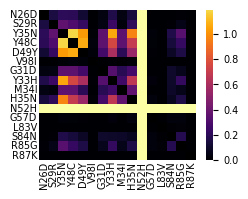

In [8]:
# combine MA and SI

# initialize matrices to store values
total_epistasis = np.zeros((num_mutations_MA,num_mutations_MA),dtype=float)


    
muts_SI = np.array([1,2,3,4,5,6,7,8,9,10,12,13,14,15,16])-1



for i in range(1,len(coefs_SI)):
    muts_involved = [int(x)-1 for x in names_SI[i].split(',')]
    if len(muts_involved) >= 2:
        if sig_SI[i]:
            for j in range(len(muts_involved)):
                for k in range(j+1,len(muts_involved)):
                    total_epistasis[muts_involved[k],muts_involved[j]] += np.abs(coefs_SI[i])
                    total_epistasis[muts_involved[j],muts_involved[k]] += np.abs(coefs_SI[i])


print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))
min_val = np.nanmin(total_epistasis)
max_val = np.nanmax(total_epistasis)


overlay = np.full((num_mutations_MA,num_mutations_MA),np.nan)

for i in range(num_mutations_MA):
    overlay[i,i] = np.nan
    total_epistasis[i,i] = np.nan

    for j in [11]:
        overlay[j-1,i] = 1
        total_epistasis[j-1,i] = np.nan
        overlay[i,j-1] = 1
        total_epistasis[i,j-1] = np.nan
            
    
mpl.rc_file_defaults() 
plt.rcParams.update({'font.size': 7,"axes.facecolor": "k"})


cmap = plt.get_cmap('inferno')
new_cmap = truncate_colormap(cmap, 0,0.9)


plt.figure(figsize=(2.5,2))

sns.heatmap(total_epistasis,cmap=new_cmap,cbar_kws={"pad": 0.05},vmax=np.nanmax(total_epistasis)) 
sns.heatmap(overlay,cmap=cmap,vmin=0,vmax=1,cbar=None) 

plt.xticks(np.arange(0.5,num_mutations_MA+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_MA+0.5,1),mut_names,rotation='0')
plt.tick_params(length=0,pad=1)

plt.tight_layout()
plt.savefig('images/CH65_SI_2andup_stat_total_'+ep_type+'.pdf')

plt.show()

## G189E

In [9]:
# read model coefficients


coefs_G189E = np.zeros(total_params_G189E+1)
stderr_G189E = np.zeros(total_params_G189E+1)
names_G189E = []
sig_G189E = np.full((total_params_G189E+1),0)
cis_G189E = np.zeros((total_params_G189E+1,2))

with open('../../Epistasis_Inference/G189E/statistical/CH65_G189E_newdata_'+str(order_G189E)+'order_stat.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    print(r2_train)
    header = next(coef_reader)
    print(header)
    for i in range(total_params_G189E+1):
        row = next(coef_reader)
        names_G189E.append(row[0])
        coefs_G189E[i] = float(row[1])
        if i >= 1:
            stderr_G189E[i] = float(row[2])
            cis_G189E[i,0] = float(row[4])
            cis_G189E[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_G189E[i] = 1
    readfile.close()
            
print(len(coefs_G189E))      

0.9878427948231131
['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper']
14893


0.0 1.8138571189546067


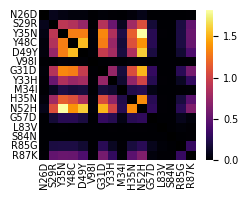

In [10]:
# initialize G189Etrices to store values

# total (lower diagonal)
total_epistasis = np.zeros((16,16),dtype=float)
for i in range(16):  
    total_epistasis[i,i] = np.nan


# add up all coefficients
for i in range(1,len(coefs_G189E)):

    muts_involved = [int(x)-1 for x in names_G189E[i].split(',')]
    
    # only consider 2nd order and higher
    if len(muts_involved) >= 2:
        if sig_G189E[i]:
            for j in range(len(muts_involved)):
                for k in range(j+1,len(muts_involved)):
                    total_epistasis[muts_involved[k],muts_involved[j]] += np.abs(coefs_G189E[i])
                    total_epistasis[muts_involved[j],muts_involved[k]] += np.abs(coefs_G189E[i])


print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))

# norG189Elize total epistasis
#print(total_sum,total_sum_signed)
#total_epistasis = total_epistasis/total_sum
#print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))
min_val = np.nanmin(total_epistasis)


#cbar_ticks = [10**i for i in range(int(np.floor(np.log10(np.nanmin(total_epistasis)))), 1+int(np.ceil(np.log10(np.nanG189Ex(total_epistasis)))))]
# for i in range(16):
#     total_epistasis[i,i] = min_val
    
sns.set_style({"axes.facecolor": "k"})       
plt.figure(figsize=(2.5,2))
sns.heatmap(total_epistasis,cmap='inferno',cbar_kws={"pad": 0.05},vmax=np.nanmax(total_epistasis)) #,vmin=0.0,vG189Ex=np.nanG189Ex(total_epistasis)) 
plt.xticks(np.arange(0.5,num_mutations_G189E+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_G189E+0.5,1),mut_names,rotation='0')
plt.tick_params(length=0,pad=1)



plt.tight_layout()
plt.savefig('images/CH65_G189E_2andup_stat_total_'+ep_type+'.pdf')
plt.show()



# Variance partitioning

In [11]:
# read in genos and phenos
df = pd.read_csv('../../Kd_Inference/results_CH65/Kd_processed/20221008_CH65_QCfilt_REPfilt.csv',dtype={"geno": str})
# MA
df_MA = df.dropna(subset=['MA90_mean'])
genos_MA = np.array(df_MA[['pos'+x for x in MA_mutations]].copy(),dtype=np.float64)
phenos_MA = df_MA[['MA90_mean']].values.flatten()
print(genos_MA.shape,phenos_MA.shape)
genos_MA = 2*genos_MA-1


poly_current_MA = PolynomialFeatures(order_MA,interaction_only=True)
genos_current_MA = poly_current_MA.fit_transform(genos_MA)

phenos_pred = np.tensordot(genos_current_MA,coefs_MA,axes=1)
pearsonr = np.corrcoef(phenos_pred,phenos_MA)[1,0]
print(pearsonr,pearsonr**2)


order_r2_MA = []
for i in range(1,order_MA+1):
    phenos_pred = np.tensordot(genos_current_MA[:,:order_start_indices_MA[i]],coefs_MA[:order_start_indices_MA[i]],axes=1)
    pearsonr = np.corrcoef(phenos_pred,phenos_MA)[1,0]
    order_r2_MA.append(pearsonr**2)
print(order_r2_MA)
var_expl = np.array(order_r2_MA)/order_r2_MA[-1]

total_ep = 1-var_expl[0]
print(total_ep)

delta_ep = list(var_expl)
delta_ep.insert(0,0)
print(delta_ep)

delta_ep = [delta_ep[i]-delta_ep[i-1] for i in range(1,6)]
print(delta_ep)


(65530, 16) (65530,)
0.9949642722434131 0.9899539030408647
[0.7550395559204273, 0.9564756159793817, 0.9800125923280919, 0.9868220836382949, 0.9899539030408647]
0.23729826853436864
[0, 0.7627017314656314, 0.966181973768024, 0.9899578044167149, 0.9968363987525584, 1.0]
[0.7627017314656314, 0.2034802423023926, 0.023775830648690932, 0.00687859433584348, 0.0031636012474416386]


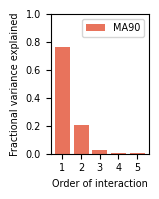

In [12]:
sns.set_style({"axes.facecolor": "w"})  
plt.figure(figsize=(1.6,2))
plt.bar(range(1,6),delta_ep,width=0.8,color=MA_color,label='MA90')
plt.ylim([0,1])
plt.ylabel('Fractional variance explained')
plt.xlabel('Order of interaction')
plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
plt.tight_layout()
plt.legend()
plt.savefig('images/CH65_MA_var_partitioning.pdf',transparent=True)
plt.show()

In [13]:
# read in genos and phenos
df = pd.read_csv('../../Kd_Inference/results_CH65/Kd_processed/20221008_CH65_QCfilt_REPfilt.csv',dtype={"variant": str})
# SI
# # for SI, remove N52H
df_SI = df.dropna(subset=['SI06_mean'])
for mut in SI_required_mutations:
    df_SI = df_SI.loc[df_SI['pos'+mut] == 1]

genos_SI = np.array(df_SI[['pos'+x for x in SI_mutations]].copy(),dtype=np.float64)
phenos_SI = df_SI[['SI06_mean']].values.flatten()
print(genos_SI.shape,phenos_SI.shape)
genos_SI = 2*genos_SI-1


poly_current_SI = PolynomialFeatures(order_SI,interaction_only=True)
genos_current_SI = poly_current_SI.fit_transform(genos_SI)

phenos_pred = np.tensordot(genos_current_SI,coefs_SI,axes=1)
pearsonr = np.corrcoef(phenos_pred,phenos_SI)[1,0]
print(pearsonr,pearsonr**2)


order_r2_SI = []
for i in range(1,order_SI+1):
    phenos_pred = np.tensordot(genos_current_SI[:,:order_start_indices_SI[i]],coefs_SI[:order_start_indices_SI[i]],axes=1)
    pearsonr = np.corrcoef(phenos_pred,phenos_SI)[1,0]
    order_r2_SI.append(pearsonr**2)
print(order_r2_SI)
var_expl = np.array(order_r2_SI)/order_r2_SI[-1]

total_ep = 1-var_expl[0]
print(total_ep)

delta_ep = list(var_expl)
delta_ep.insert(0,0)
print(delta_ep)

delta_ep = [delta_ep[i]-delta_ep[i-1] for i in range(1,order_SI+1)]
print(delta_ep)


(31924, 15) (31924,)
0.9828101366484356 0.9659157646989167
[0.6358653435397063, 0.8783333531633619, 0.9333692185619964, 0.9521917555566063, 0.9659157646989167]
0.3416968986546044
[0, 0.6583031013453956, 0.9093270710175696, 0.9663049850448757, 0.9857917122342564, 1.0]
[0.6583031013453956, 0.251023969672174, 0.05697791402730612, 0.019486727189380715, 0.014208287765743566]


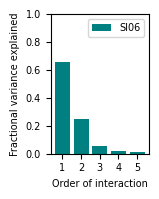

In [14]:
plt.figure(figsize=(1.6,2))
plt.bar(range(1,order_SI+1),delta_ep,width=0.8,color=SI_color,label='SI06')
plt.ylim([0,1])
plt.ylabel('Fractional variance explained')
plt.xlabel('Order of interaction')
plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
plt.legend()
plt.tight_layout()
plt.savefig('images/CH65_SI_var_partitioning.pdf')
plt.show()

In [18]:
# read in genos and phenos
df = pd.read_csv('../../Kd_Inference/results_CH65/Kd_processed/20221008_CH65_QCfilt_REPfilt.csv',dtype={"geno": str})
# G189E
df_G189E = df.dropna(subset=['G189E_mean'])
genos_G189E = np.array(df_G189E[['pos'+x for x in G189E_mutations]].copy(),dtype=np.float64)
phenos_G189E = df_G189E[['G189E_mean']].values.flatten()
print(genos_G189E.shape,phenos_G189E.shape)
genos_G189E = 2*genos_G189E-1


poly_current_G189E = PolynomialFeatures(order_G189E,interaction_only=True)
genos_current_G189E = poly_current_G189E.fit_transform(genos_G189E)

phenos_pred = np.tensordot(genos_current_G189E,coefs_G189E,axes=1)
pearsonr = np.corrcoef(phenos_pred,phenos_G189E)[1,0]
print(pearsonr,pearsonr**2)


order_r2_G189E = []
for i in range(1,order_G189E+1):
    phenos_pred = np.tensordot(genos_current_G189E[:,:order_start_indices_G189E[i]],coefs_G189E[:order_start_indices_G189E[i]],axes=1)
    pearsonr = np.corrcoef(phenos_pred,phenos_G189E)[1,0]
    order_r2_G189E.append(pearsonr**2)
print(order_r2_G189E)
var_expl = np.array(order_r2_G189E)/order_r2_G189E[-1]

total_ep = 1-var_expl[0]
print(total_ep)

delta_ep = list(var_expl)
delta_ep.insert(0,0)
print(delta_ep)

delta_ep = [delta_ep[i]-delta_ep[i-1] for i in range(1,7)]
print(delta_ep)


(63840, 16) (63840,)
0.9939028095458384 0.9878427948231112
[0.7371154025601113, 0.915706184859103, 0.9523319356296139, 0.9702114829502755, 0.9818049368158457, 0.9878427948231112]
0.2538130495833566
[0, 0.7461869504166434, 0.9269756176366855, 0.964052114992795, 0.9821517027150126, 0.9938878351505852, 1.0]
[0.7461869504166434, 0.18078866722004205, 0.03707649735610952, 0.018099587722217647, 0.011736132435572588, 0.006112164849414792]


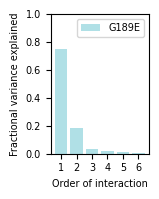

In [19]:
sns.set_style({"axes.facecolor": "w"})  
plt.figure(figsize=(1.6,2))
plt.bar(range(1,7),delta_ep,width=0.8,color=G189E_color,label='G189E')
plt.ylim([0,1])
plt.ylabel('Fractional variance explained')
plt.xlabel('Order of interaction')
plt.xticks([1,2,3,4,5,6],['1','2','3','4','5','6'])
plt.tight_layout()
plt.legend()
plt.savefig('images/CH65_G189E_var_partitioning.pdf',transparent=True)
plt.show()